A __pre-trained__ model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as it is, or use __transfer learning__ to customize this model to a given task.

The intuition behind transfer learning is that if a model trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch training a large model on a large dataset.

<a href=https://www.tensorflow.org/tutorials/images/transfer_learning>Source</a>

Keras contains 10 pretrained models for image classification which are trained
on <a href='http://www.image-net.org/'>ImageNet</a>.

ImageNet is a dataset of over 15 million labeled high-resolution images belonging to roughly 22,000 categories.

__Simplified CNN architecture:__
- Feature extractor (Convolutions+Pooling)
- Classifier (Fully Connected layers)

<img src = "https://qph.fs.quoracdn.net/main-qimg-9eba847cb0342a019bbd49bafe010b47" width = 800>

In [27]:
#from google.colab import drive
#drive.mount('/content/drive')

In [28]:
import zipfile
!rm /content/download

!rm -r /content/mammals/train
!rm -r /content/mammals/test
!wget https://vc.ee.duth.gr:6960/index.php/s/HUtNngKpQctMI1x/download
local_zip = '/content/download'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

train_dir = '/content/mammals/train'
test_dir = '/content/mammals/test'

--2024-02-04 14:46:13--  https://vc.ee.duth.gr:6960/index.php/s/HUtNngKpQctMI1x/download
Resolving vc.ee.duth.gr (vc.ee.duth.gr)... 83.212.140.54
Connecting to vc.ee.duth.gr (vc.ee.duth.gr)|83.212.140.54|:6960... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20285846 (19M) [application/zip]
Saving to: ‘download’

download            100%[===================>]  19.35M  9.67MB/s    in 2.0s    

2024-02-04 14:46:16 (9.67 MB/s) - ‘download’ saved [20285846/20285846]



## VGG

<img src = "https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" width = 800>

In [29]:
from keras.applications import vgg16
#Load the VGG model
vgg_conv = vgg16.VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(256, 256, 3))

In [30]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# # Check the trainable status of the individual layers
# for layer in vgg_conv.layers:
#     print(layer, layer.trainable)

In [31]:
from keras import models
from keras import layers
from keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 1024)              33555456  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 48275269 (184.16 MB)
Trainable params: 40640005 (155.03 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [32]:
import os
base_dir = '/content/mammals'

train_dir = os.path.join(base_dir, 'train')

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input, validation_split=0.2)
#train_datagen  = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    # color_mode='grayscale',
                                                    target_size=(256,256),
                                                    shuffle=True,
                                                    subset='training', seed=1)
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  train_datagen.flow_from_directory(train_dir,
                                                        batch_size=20,
                                                        class_mode='categorical',
                                                        #  color_mode='grayscale',
                                                         target_size=(256,256),
                                                        subset='validation', seed=1)

Found 997 images belonging to 5 classes.
Found 248 images belonging to 5 classes.


In [34]:
import tensorflow as tf

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

callbacks = []

save_best_callback = tf.keras.callbacks.ModelCheckpoint(f'best_weights.hdf5', save_best_only=True, verbose=1)
callbacks.append(save_best_callback)

early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
callbacks.append(early_stop_callback)


# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=6,
      validation_data=validation_generator,
      verbose=1,
      callbacks=callbacks)

# Save the model
model.save('small_last4.h5')

Epoch 1/6
50/49 [==============================] - ETA: 0s - loss: 2.2556 - accuracy: 0.8104
Epoch 1: val_loss improved from inf to 0.79163, saving model to best_weights.hdf5
49/49 [==============================] - 14s 236ms/step - loss: 2.2556 - accuracy: 0.8104 - val_loss: 0.7916 - val_accuracy: 0.8790
Epoch 2/6
50/49 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.9679
Epoch 2: val_loss improved from 0.79163 to 0.34834, saving model to best_weights.hdf5
49/49 [==============================] - 11s 227ms/step - loss: 0.1750 - accuracy: 0.9679 - val_loss: 0.3483 - val_accuracy: 0.9073
Epoch 3/6
50/49 [==============================] - ETA: 0s - loss: 0.0356 - accuracy: 0.9890
Epoch 3: val_loss improved from 0.34834 to 0.17282, saving model to best_weights.hdf5
49/49 [==============================] - 11s 216ms/step - loss: 0.0356 - accuracy: 0.9890 - val_loss: 0.1728 - val_accuracy: 0.9395
Epoch 4/6
50/49 [==============================] - ETA: 0s - loss: 0.00

In [35]:
test_datagen  = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)
test_dir = os.path.join(base_dir, 'test')
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                        batch_size=10,
                                                        class_mode='categorical',
                                                        #  color_mode='grayscale',
                                                         target_size=(256,256))
loss, acc = model.evaluate(test_generator)

Found 250 images belonging to 5 classes.
25/25 [==============================] - 2s 67ms/step - loss: 0.1810 - accuracy: 0.9680


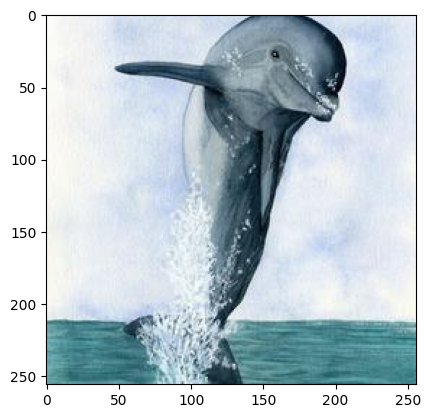

1/1 [==============================] - 0s 141ms/step



['bear', 'camel', 'giraffe', 'dolphin', 'squirrel']



Softmax Output: [[5.6469507e-18 5.2440470e-14 1.0000000e+00 6.4250404e-11 2.6997687e-11]]



/content/mammals/test/dolphin/dolphin-0289.jpg is a giraffe





In [36]:
from keras.utils import load_img, img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

path = '/content/mammals/test/dolphin/dolphin-0289.jpg'
img = load_img(path, target_size=(256, 256), grayscale=False, interpolation='bilinear')
plt.imshow(img, cmap='gray')
plt.show()

model = tf.keras.models.load_model('/content/small_last4.h5')
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

classes_pred = model.predict(x)
classes = ['bear', 'camel', 'giraffe', 'dolphin', 'squirrel']
print(f'\n\n\n{classes}')
print(f'\n\n\nSoftmax Output: {classes_pred}')
print(f'\n\n\n{path} is a {classes[classes_pred.argmax()]}\n\n\n')


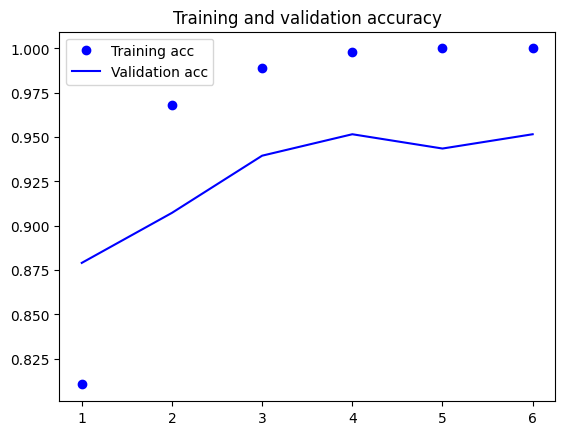

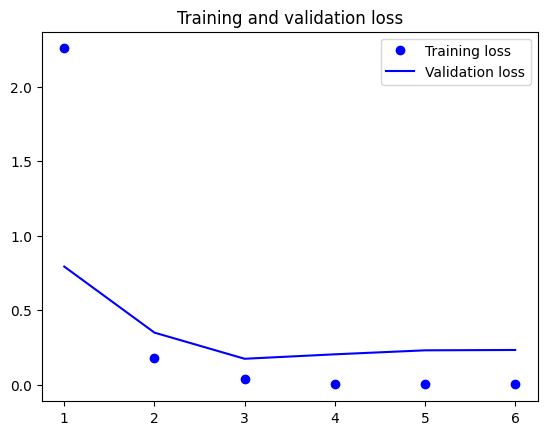

In [37]:
import matplotlib.pyplot as plt

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()